In [1]:
%matplotlib widget

In [2]:
import flammkuchen as fl
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import json
import imageio
from scipy.stats import sem
import seaborn as sns
from bouter.free import FreelySwimmingExperiment
import pandas as pd
from scipy import signal
from tqdm import tqdm
from scipy.stats import zscore
from scipy.interpolate import interp1d
from sklearn.neighbors import KernelDensity as kde
from scipy.stats import linregress
from scipy.signal import medfilt
from scipy.signal import savgol_filter
from scipy.stats import mannwhitneyu, ttest_1samp
import random

In [3]:
def clip(x_):
    x_[x_>200]=200
    x_[x_<0]= 0
    return x_
def clean_augment(x_,stim_fun,setpoint):
    out_ = []
    for df_ in x_:
        if "flip_x_start" in df_.keys():
            pass
        else:
            df_["flip_x_start"] = df_["al_start_x"]
            df_["flip_y_start"] = df_["al_start_y"]
            
            df_["flip_x_end"] = df_["al_end_x"]
            df_["flip_y_end"] = df_["al_end_y"]
        df_["flip_x_start"] = clip(df_["flip_x_start"].values)
        try:
            df_["flip_x_end"] = clip(df_["flip_x_end"].values)
        except:
            df_["flip_x_end"] = clip(df_["al_end_x"].values)
        out_.append(augment(df_,stim_fun,setpoint))
    return out_

def clean_augment_cpca(x_,stim_fun,setpoint):
    out_ = []
    for df_ in x_:
        df_["flip_x_start"] = abs(200-clip(df_["flip_x_start"].values))
        out_.append(augment(df_,stim_fun,setpoint))
    return out_

def dist_setpoint(values,setpoint):
    return abs(values - setpoint)

def augment(bout_properties,fun,setpoint,time_th=2):
    border_x = [10, 190]
    border_y = [5, 45]
    x_start = []
    x_end = []
    temp_start = []
    temp_end = []
    temp_pre = []
    delta = []
    delta_prev = []
    out = []
    prev_biases = []
    temporal_distance = []
    prev_bout = None
    prev_bias = None
    prev_temp = None
    delta_prev_prev_bout = None
    delta_prev_bout = np.nan
    for i in range(len(bout_properties)):
        
        bout = bout_properties.iloc[i]
        if prev_bout is not None:
            temporal_distance = bout["t_start"] - prev_bout["t_end"] 
            if (temporal_distance <= time_th)& (delta_prev_bout!=np.nan):
                delta_prev_prev_bout = delta_prev_bout
            else:
                delta_prev_prev_bout  = np.nan
                
        if prev_bout is not None:
            temporal_distance = bout["t_start"] - prev_bout["t_end"] 
            if temporal_distance <= time_th:
                prev_bias = prev_bout["theta_bout"]
                
                delta_prev_bout = dist_setpoint(float(fun(prev_bout["flip_x_start"])),setpoint) - dist_setpoint(float(fun(bout["flip_x_start"])),setpoint)
                prev_temp = dist_setpoint(float(fun(prev_bout["flip_x_start"])),setpoint)
            else:
                delta_prev_bout  = np.nan
                prev_bias = np.nan
                prev_temp = np.nan
            
        temp_start.append(dist_setpoint(float(fun(bout["flip_x_start"])),setpoint))
        delta.append(delta_prev_bout)
        delta_prev.append(delta_prev_prev_bout)
        x_start.append(bout['flip_x_start'])
        temp_pre.append(prev_temp)
        prev_biases.append(prev_bias)
        if (border_x[0] <= bout["flip_x_start"] <= border_x[1]) and (border_y[0] <= bout["y_start"] <= border_y[1]):
            is_out = False
        else:
            is_out = True
        out.append(is_out)
        prev_bout = bout.copy()
    bout_properties["temp_start"] = temp_start
    bout_properties["delta"]=delta
    bout_properties["delta_1"]=delta_prev
    bout_properties["out"]=out
    bout_properties["prev_bias"]=prev_biases
    bout_properties["prev_temp"] = temp_pre
    return bout_properties

def prefered_temperature(x_position,times,resolution=2):
    result = medfilt(np.interp(np.linspace(0,15*60,15*60*resolution),
            times,x_position),3)
    return np.nanmedian(result[600*resolution:])

def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh) 

In [4]:
plt.rcParams.update({'font.size': 25})

In [5]:
setpoint_wt = 25.280104571722397
setpoint_hb = 27.89187878451635
setpoint_abl = 27.181914005550055

In [253]:
full_dataset = fl.load(r"Z:\experiments\virtual_gradients_experiments\freely_swim_Ruben\data.h5")

transfer_fun = interp1d(full_dataset["stimulus_calibration"][0,:],
                             full_dataset["stimulus_calibration"][1,:],
                             kind="quadratic")
WT = clean_augment(full_dataset["WT"].copy(),transfer_fun,setpoint_wt)


In [254]:
spont = clean_augment(full_dataset["no_stim"].copy(),transfer_fun,setpoint_wt)

In [12]:
bins_theta = np.arange(0,np.deg2rad(100),np.deg2rad(20))
hists = []
for fish_ in spont:
    bouts_in_bin = abs(fish_.iloc[(fish_["delta"].values>=0.1333)]["theta_bout"])
    c,_ = np.histogram(bouts_in_bin,bins_theta)
    c = c / np.sum(c)
    
    bouts_in_bin = abs(fish_.iloc[(fish_["delta"].values<=-0.1333)]["theta_bout"])
    c0,_ = np.histogram(bouts_in_bin,bins_theta)
    c0 = c0 / np.sum(c0)
    
    hists.append(np.array([c,c0]))
hists = np.stack(hists)

In [278]:
colors = ["#8e530b","#036860"]

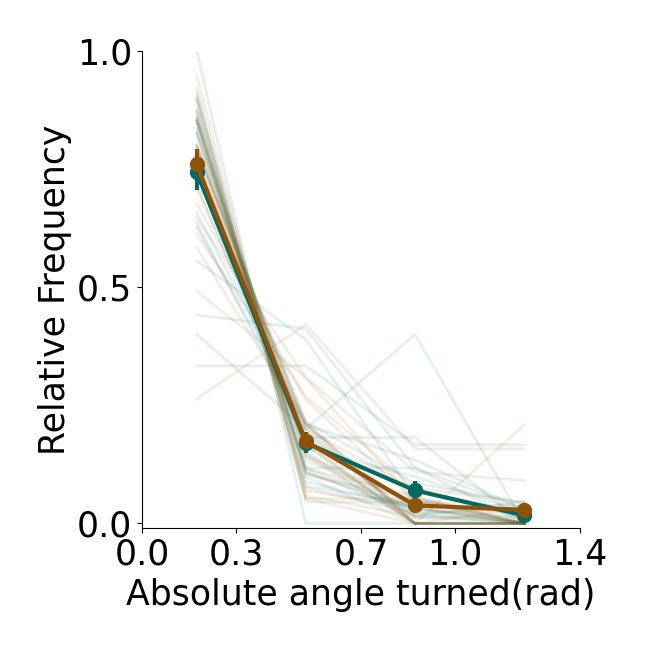

In [18]:
bins_center = (bins_theta[1:]+bins_theta[:-1])/2
plt.figure()

plt.plot(bins_center,hists[:,0,:].T,lw=2,color=colors[-1],alpha=.1)

plt.plot(bins_center,hists[:,1,:].T,lw=2,color=colors[0],alpha=.1)

plt.errorbar(bins_center,np.nanmean(hists[:,0,:],0),
             yerr=sem(hists[:,0,:],0,nan_policy="omit"),
            lw=3,fmt="-",ms=6,marker="o",mew=5,c=colors[1],
            capthick=5)

plt.errorbar(bins_center,np.nanmean(hists[:,1,:],0),
             yerr=sem(hists[:,-1,:],0,nan_policy="omit"),
            lw=3,fmt="-",ms=6,marker="o",mew=5,c=colors[0],
            capthick=5)

# plt.text(bins_center[0]-.04,0.8,"*",color="k",fontsize=40,fontweight="bold")
# plt.text(bins_center[1]-.04,0.35,"*",color="k",fontsize=40,fontweight="bold")

plt.ylabel("Relative Frequency",fontsize=25)
plt.xlabel("Absolute angle turned(rad)",fontsize=25)
plt.yticks([0,.5,1],fontsize=25)
plt.ylim([-.01,1])
plt.xlim(bins_theta[0],bins_theta[-1])
plt.xticks(np.round(bins_theta,1),fontsize=25)
set_size(5,5)
sns.despine()
plt.tight_layout()
plt.show()
plt.savefig(r"C:\Users\ge59xan\Desktop\new_figs_new\figures_reviews\rev2_point1_0_SpontWCxtICxt.png",dpi=800)

In [16]:
for i in range(hists.shape[-1]):
    print(mannwhitneyu(hists[:,0,i],hists[:,1,i])[1])

0.8691019179476038
0.886427522928373
0.3934228856700638
0.4815991407847138


### motor memory

In [19]:
from scipy.stats import wilcoxon

In [402]:
th_min_bouts = 0
iso_th = 0.133
th_ = 30
n_reps = 100
turn_th = np.deg2rad(30)


In [445]:

ipsi_index_WT = []
ipsi_index_WT_random = []

for fish_ in WT:
    distant = fish_["temp_start"].values > 1
    temp_past = fish_["prev_temp"].values-fish_["delta_1"].values
    delta_past = fish_["prev_temp"].values - temp_past
    where_turn = abs(fish_["prev_bias"].values) >= turn_th
    fish_ = fish_.iloc[(fish_["delta"].values<-iso_th)&distant]
    if len(fish_) > th_min_bouts:

        num_ipsi = fish_["theta_bout"].values[abs(fish_["prev_bias"])>np.deg2rad(th_)]*np.sign(fish_["prev_bias"].values[abs(fish_["prev_bias"])>np.deg2rad(th_)])
#         ipsi_index_WT.append(np.sum(num_ipsi>0) / num_ipsi.shape[0])
        ipsi_index_WT.append(np.nanmedian(num_ipsi))
        
ipsi_index_WT = np.array(ipsi_index_WT)

ipsi_index_WT_down = []

for fish_ in WT:
    distant = fish_["temp_start"].values > 1
    temp_past = fish_["prev_temp"].values-fish_["delta_1"].values
    delta_past = fish_["prev_temp"].values - temp_past
    where_turn = abs(fish_["prev_bias"].values) >= turn_th
    fish_ = fish_.iloc[(fish_["delta"].values>-iso_th)&distant]
    if len(fish_) > th_min_bouts:

        num_ipsi = fish_["theta_bout"].values[abs(fish_["prev_bias"])>np.deg2rad(th_)]*np.sign(fish_["prev_bias"].values[abs(fish_["prev_bias"])>np.deg2rad(th_)])
#         ipsi_index_WT_down.append(np.sum(num_ipsi>0) / num_ipsi.shape[0])
        ipsi_index_WT_down.append(np.nanmedian(num_ipsi))
        
ipsi_index_WT_down = np.array(ipsi_index_WT_down)

ipsi_index_spont = []
ipsi_index_spont_random = []

for fish_ in spont:
    if len(fish_) > th_min_bouts:

        num_ipsi = fish_["theta_bout"].values[abs(fish_["prev_bias"])>np.deg2rad(th_)]*np.sign(fish_["prev_bias"].values[abs(fish_["prev_bias"])>np.deg2rad(th_)])
#         ipsi_index_spont.append(np.sum(num_ipsi>0) / num_ipsi.shape[0])
        ipsi_index_spont.append(np.nanmedian(num_ipsi))
        
ipsi_index_spont = np.array(ipsi_index_spont)




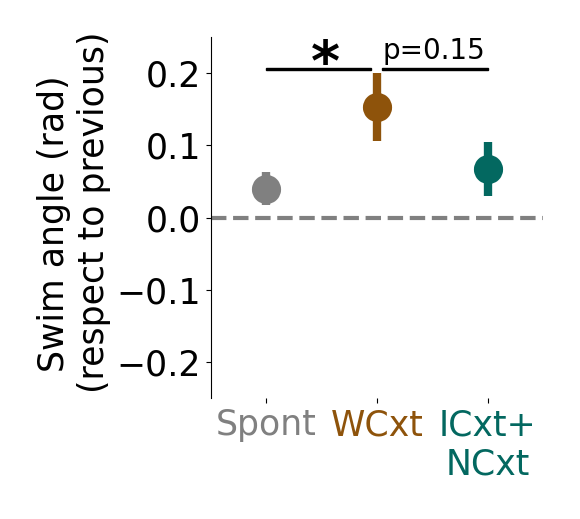

In [447]:
plt.figure(figsize=(3,5))
plt.plot([-3.5,-0.5],[0,0],"--",c="gray",lw=3)

to_plot = ipsi_index_spont.copy()
plt.errorbar([-3],y=np.array([np.nanmean(to_plot)]),
            yerr=sem(to_plot,nan_policy="omit"),
            lw=6,fmt="-",ms=14,marker="o",mew=7,c="gray",
            capthick=5)

to_plot = ipsi_index_WT.copy()
plt.errorbar([-2],y=np.array([np.nanmean(to_plot)]),
            yerr=sem(to_plot,nan_policy="omit"),
            lw=6,fmt="-",ms=14,marker="o",mew=7,c=colors[0],
            capthick=5)

to_plot = ipsi_index_WT_down.copy()
plt.errorbar([-1],y=np.array([np.nanmean(to_plot)]),
            yerr=sem(to_plot,nan_policy="omit"),
            lw=6,fmt="-",ms=14,marker="o",mew=7,c=colors[1],
            capthick=5)

plt.axvspan(-3,-2.05,.91,.915,color="k")
plt.text(-2.6,0.19,"*",color="k",fontsize=40,fontweight="bold")

plt.axvspan(-1.95,-1,.91,.915,color="k")
plt.text(-1.95,0.22,"p=0.15",color="k",fontsize=20)

    
plt.xlim([-3.5,-0.5])
plt.ylim([-.25,.25])
plt.yticks([-.2,-.1,0,.1,.2],fontsize=25)
plt.xticks([-3,-2,-1],["Spont","WCxt", "ICxt+\nNCxt"],fontsize=25)
for ticklabel, tickcolor in zip(plt.gca().get_xticklabels(), ["gray",colors[0],colors[1]]):
    ticklabel.set_color(tickcolor)
plt.ylabel("Swim angle (rad) \n (respect to previous)",fontsize=25)
sns.despine(bottom=True)
set_size(4.5,4)
plt.tight_layout()
plt.show()
# plt.savefig(r"C:\Users\ge59xan\Desktop\new_figs_new\figures_reviews\rev2_point1_1_SpontWCxtICxt.png",dpi=800)

In [444]:
print(wilcoxon(ipsi_index_WT[np.isfinite(ipsi_index_WT)],
                   ipsi_index_spont[np.isfinite(ipsi_index_spont)],
                  )[1])

0.16952300071716309


In [443]:
print(wilcoxon(ipsi_index_WT[np.isfinite(ipsi_index_WT)],
                   ipsi_index_WT_down[np.isfinite(ipsi_index_WT_down)],
                  wilcoxon)[1])

ValueError: Zero method must be either 'wilcox' or 'pratt' or 'zsplit'

In [345]:
th_min_bouts = 15
iso_th = 0.133
th_ = 30
n_reps = 100
turn_th = np.deg2rad(0)

In [346]:
ipsi_index_WT = []
ipsi_index_WT_random = []

for fish_ in WT:
    distant = fish_["temp_start"].values > 1
    temp_past = fish_["prev_temp"].values-fish_["delta_1"].values
    delta_past = fish_["prev_temp"].values - temp_past
    where_turn = abs(fish_["prev_bias"].values) >= turn_th
    fish_ = fish_.iloc[(fish_["delta"].values<-iso_th)&distant]
    if len(fish_) > th_min_bouts:

        num_ipsi = fish_["theta_bout"].values[abs(fish_["prev_bias"])>np.deg2rad(th_)]*np.sign(fish_["prev_bias"].values[abs(fish_["prev_bias"])>np.deg2rad(th_)])
        ipsi_index_WT.append(np.sum(num_ipsi>0) / num_ipsi.shape[0])
#         ipsi_index_WT.append(np.nanmedian(num_ipsi))
        
ipsi_index_WT = np.array(ipsi_index_WT)

ipsi_index_WT_down = []

for fish_ in WT:
    distant = fish_["temp_start"].values > 1
    temp_past = fish_["prev_temp"].values-fish_["delta_1"].values
    delta_past = fish_["prev_temp"].values - temp_past
    where_turn = abs(fish_["prev_bias"].values) >= turn_th
    fish_ = fish_.iloc[(fish_["delta"].values>-iso_th)&distant]
    if len(fish_) > th_min_bouts:

        num_ipsi = fish_["theta_bout"].values[abs(fish_["prev_bias"])>np.deg2rad(th_)]*np.sign(fish_["prev_bias"].values[abs(fish_["prev_bias"])>np.deg2rad(th_)])
        ipsi_index_WT_down.append(np.sum(num_ipsi>0) / num_ipsi.shape[0])
#         ipsi_index_WT_down.append(np.nanmedian(num_ipsi))
        
ipsi_index_WT_down = np.array(ipsi_index_WT_down)

ipsi_index_spont = []
ipsi_index_spont_random = []

for fish_ in spont:
    if len(fish_) > th_min_bouts:

        num_ipsi = fish_["theta_bout"].values[abs(fish_["prev_bias"])>np.deg2rad(th_)]*np.sign(fish_["prev_bias"].values[abs(fish_["prev_bias"])>np.deg2rad(th_)])
        ipsi_index_spont.append(np.sum(num_ipsi>0) / num_ipsi.shape[0])
#         ipsi_index_spont.append(np.nanmedian(num_ipsi))
        
ipsi_index_spont = np.array(ipsi_index_spont)

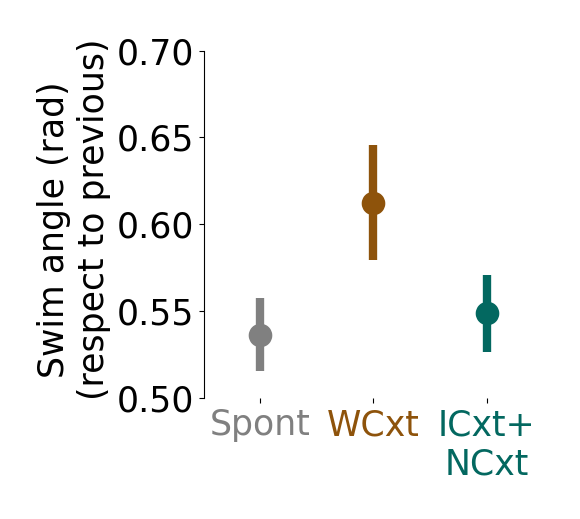

In [350]:
plt.figure(figsize=(3,5))
plt.plot([-3.5,-0.5],[0,0],"--",c="gray",lw=3)

to_plot = ipsi_index_spont.copy()
plt.errorbar([-3],y=np.array([np.nanmean(to_plot)]),
            yerr=sem(to_plot,nan_policy="omit"),
            lw=6,fmt="-",ms=10,marker="o",mew=7,c="gray",
            capthick=5)

to_plot = ipsi_index_WT.copy()
plt.errorbar([-2],y=np.array([np.nanmean(to_plot)]),
            yerr=sem(to_plot,nan_policy="omit"),
            lw=6,fmt="-",ms=10,marker="o",mew=7,c=colors[0],
            capthick=5)

to_plot = ipsi_index_WT_down.copy()
plt.errorbar([-1],y=np.array([np.nanmean(to_plot)]),
            yerr=sem(to_plot,nan_policy="omit"),
            lw=6,fmt="-",ms=10,marker="o",mew=7,c=colors[1],
            capthick=5)

# plt.axvspan(-3,-2.1,.9,.905,color="k")
# plt.text(-2.75,0.265,"**",color="k",fontsize=40,fontweight="bold")

    
plt.xlim([-3.5,-0.5])
plt.ylim([.5,.7])
# plt.yticks([-.2,-.1,0,.1,.2],fontsize=25)
plt.xticks([-3,-2,-1],["Spont","WCxt", "ICxt+\nNCxt"],fontsize=25)
for ticklabel, tickcolor in zip(plt.gca().get_xticklabels(), ["gray",colors[0],colors[1]]):
    ticklabel.set_color(tickcolor)
plt.ylabel("Swim angle (rad) \n (respect to previous)",fontsize=25)
sns.despine(bottom=True)
set_size(4.5,4)
plt.tight_layout()
plt.show()

In [352]:
print(mannwhitneyu(ipsi_index_WT[np.isfinite(ipsi_index_WT)],
                   ipsi_index_spont[np.isfinite(ipsi_index_spont)],
                  alternative="greater")[1])

0.05661630237251917


In [354]:
print(mannwhitneyu(ipsi_index_WT[np.isfinite(ipsi_index_WT)],
                   ipsi_index_WT_down[np.isfinite(ipsi_index_WT_down)],
                  alternative="greater")[1])

0.06298238076846593


In [355]:
###others

In [356]:
Hbpos_pre = clean_augment(full_dataset["Hbpos_pre_ablation"].copy(),transfer_fun,setpoint_hb)
Hbneg_post = clean_augment(full_dataset["Hbneg_post_ablation"].copy(),transfer_fun,setpoint_hb)
Hbpos_post = clean_augment(full_dataset["Hbpos_ablation"].copy(),transfer_fun,setpoint_hb)

In [366]:
ipsi_index_Hbpos_post = []

for fish_ in Hbpos_post:
    distant = fish_["temp_start"].values > 1
    temp_past = fish_["prev_temp"].values-fish_["delta_1"].values
    delta_past = fish_["prev_temp"].values - temp_past
    where_turn = abs(fish_["prev_bias"].values) >= turn_th
    fish_ = fish_.iloc[(fish_["delta"].values<-iso_th)&distant]
    if len(fish_) > th_min_bouts:

        num_ipsi = fish_["theta_bout"].values[abs(fish_["prev_bias"])>np.deg2rad(th_)]*np.sign(fish_["prev_bias"].values[abs(fish_["prev_bias"])>np.deg2rad(th_)])
        ipsi_index_Hbpos_post.append(np.sum(num_ipsi>0) / num_ipsi.shape[0])
#         ipsi_index_WT.append(np.nanmedian(num_ipsi))
        
ipsi_index_Hbpos_post = np.array(ipsi_index_Hbpos_post)

ipsi_index_Hbpos_pre = []

for fish_ in Hbpos_pre:
    distant = fish_["temp_start"].values > 1
    temp_past = fish_["prev_temp"].values-fish_["delta_1"].values
    delta_past = fish_["prev_temp"].values - temp_past
    where_turn = abs(fish_["prev_bias"].values) >= turn_th
    fish_ = fish_.iloc[(fish_["delta"].values>-iso_th)&distant]
    if len(fish_) > th_min_bouts:

        num_ipsi = fish_["theta_bout"].values[abs(fish_["prev_bias"])>np.deg2rad(th_)]*np.sign(fish_["prev_bias"].values[abs(fish_["prev_bias"])>np.deg2rad(th_)])
        ipsi_index_Hbpos_pre.append(np.sum(num_ipsi>0) / num_ipsi.shape[0])
#         ipsi_index_WT_down.append(np.nanmedian(num_ipsi))
        
ipsi_index_Hbpos_pre = np.array(ipsi_index_Hbpos_pre)


ipsi_index_Hbneg_post = []

for fish_ in Hbneg_post:
    distant = fish_["temp_start"].values > 1
    temp_past = fish_["prev_temp"].values-fish_["delta_1"].values
    delta_past = fish_["prev_temp"].values - temp_past
    where_turn = abs(fish_["prev_bias"].values) >= turn_th
    fish_ = fish_.iloc[(fish_["delta"].values>-iso_th)&distant]
    if len(fish_) > th_min_bouts:

        num_ipsi = fish_["theta_bout"].values[abs(fish_["prev_bias"])>np.deg2rad(th_)]*np.sign(fish_["prev_bias"].values[abs(fish_["prev_bias"])>np.deg2rad(th_)])
        ipsi_index_Hbneg_post.append(np.sum(num_ipsi>0) / num_ipsi.shape[0])
#         ipsi_index_WT_down.append(np.nanmedian(num_ipsi))
        
ipsi_index_Hbneg_post = np.array(ipsi_index_Hbneg_post)

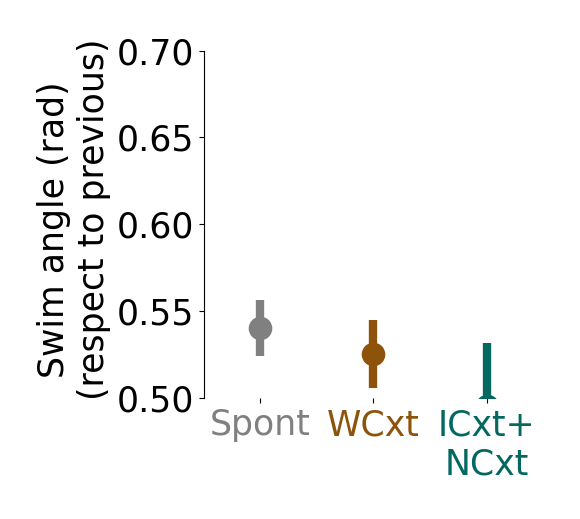

In [368]:
plt.figure(figsize=(3,5))
plt.plot([-3.5,-0.5],[0,0],"--",c="gray",lw=3)

to_plot = ipsi_index_Hbpos_pre.copy()
plt.errorbar([-3],y=np.array([np.nanmedian(to_plot)]),
            yerr=sem(to_plot,nan_policy="omit"),
            lw=6,fmt="-",ms=10,marker="o",mew=7,c="gray",
            capthick=5)

to_plot = ipsi_index_Hbneg_post.copy()
plt.errorbar([-2],y=np.array([np.nanmedian(to_plot)]),
            yerr=sem(to_plot,nan_policy="omit"),
            lw=6,fmt="-",ms=10,marker="o",mew=7,c=colors[0],
            capthick=5)

to_plot = ipsi_index_Hbpos_post.copy()
plt.errorbar([-1],y=np.array([np.nanmedian(to_plot)]),
            yerr=sem(to_plot,nan_policy="omit"),
            lw=6,fmt="-",ms=10,marker="o",mew=7,c=colors[1],
            capthick=5)

# plt.axvspan(-3,-2.1,.9,.905,color="k")
# plt.text(-2.75,0.265,"**",color="k",fontsize=40,fontweight="bold")

    
plt.xlim([-3.5,-0.5])
plt.ylim([.5,.7])
# plt.yticks([-.2,-.1,0,.1,.2],fontsize=25)
plt.xticks([-3,-2,-1],["Spont","WCxt", "ICxt+\nNCxt"],fontsize=25)
for ticklabel, tickcolor in zip(plt.gca().get_xticklabels(), ["gray",colors[0],colors[1]]):
    ticklabel.set_color(tickcolor)
plt.ylabel("Swim angle (rad) \n (respect to previous)",fontsize=25)
sns.despine(bottom=True)
set_size(4.5,4)
plt.tight_layout()
plt.show()